In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, wget, shutil
from scipy.stats import pearsonr
from itertools import combinations
import math, shap
from rich import print

In [54]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

df = pd.read_csv("data/" + filename, delim_whitespace="\t")
df = df[["age", "Weight", "Height"]].dropna()
df.head(3)

100% [..........................................................] 39886 / 39886

Original file downloaded.

,age,Weight,Height
0,19,58.0,178.0
1,19,49.0,155.0
2,19,46.0,169.0


In [71]:
import random

subjects = [{'age': random.randint(15, 50), 
           'Weight': round(random.uniform(50, 100), 1),
           'Height': round(random.uniform(1.5, 1.8), 2)} 
          for _ in range(5)]

df = pd.DataFrame(subjects)
df

,age,Weight,Height
0,17,86.9,1.60
1,17,55.2,1.79
2,45,53.3,1.53
3,31,70.2,1.61
4,25,97.0,1.74


In [138]:
data = np.array(df)
loo_data = np.array([(np.delete(data, i, axis=0)) for i in range(len(data))])
print(f"loo_data: {loo_data}")
loo_output = np.array([user_output(loo_data[i]) for i in range(5)])
print(f"loo_output: {loo_output}")


loo_data: [[[17.   55.2   1.79]
  [45.   53.3   1.53]
  [31.   70.2   1.61]
  [25.   97.    1.74]]

 [[17.   86.9   1.6 ]
  [45.   53.3   1.53]
  [31.   70.2   1.61]
  [25.   97.    1.74]]

 [[17.   86.9   1.6 ]
  [17.   55.2   1.79]
  [31.   70.2   1.61]
  [25.   97.    1.74]]

 [[17.   86.9   1.6 ]
  [17.   55.2   1.79]
  [45.   53.3   1.53]
  [25.   97.    1.74]]

 [[17.   86.9   1.6 ]
  [17.   55.2   1.79]
  [45.   53.3   1.53]
  [31.   70.2   1.61]]]

loo_output: [[29.5    68.925   1.6675]
 [29.5    76.85    1.62  ]
 [22.5    77.325   1.685 ]
 [26.     73.1     1.665 ]
 [27.5    66.4     1.6325]]

array([4.5  , 6.12 , 0.034])

In [143]:
sensitivity = np.max(np.abs(loo_output - np.mean(loo_output, axis=0)), axis = 0)
print(f"L1 sens: {np.abs(loo_output - np.mean(loo_output, axis=0))}")
print(f"sensitivity: {sensitivity}")

L1 sens: [[2.5    3.595  0.0135]
 [2.5    4.33   0.034 ]
 [4.5    4.805  0.031 ]
 [1.     0.58   0.011 ]
 [0.5    6.12   0.0215]]

sensitivity: [4.5   6.12  0.034]

In [144]:
loo_scale = np.std(loo_data, axis=0)
print(f"\n\tnoise scale: {loo_scale}")

sensitivity = np.max(np.abs(loo_output - np.mean(loo_output, axis=0)), axis = 0)

for i in range(5):
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale[i])
        if np.all(np.abs(noise) >= sensitivity):
            break
    
print(f"\n\tnoise: {noise}")
dgp_resut = pipeline_output + noise;
print(f"\n\tdgp result: {dgp_resut}")

noise scale: [[ 0.         12.68        0.076     ]
 [13.71714256  0.9308061   0.12737347]
 [ 6.85857128  8.27927533  0.03919184]
 [ 2.4        10.72        0.052     ]]

KeyboardInterrupt: 

In [145]:
def user_output(clean_data):

    return np.mean(clean_data, axis=0)

def dp(clean_data, pipeline_output):

    n_samples, n_features = clean_data.shape[1:]
    loo_outputs = np.zeros((n_samples, n_features))
    
    for i in range(n_samples):
        loo_data = np.delete(clean_data, i, axis=0)
        loo_outputs[i] = user_output(loo_data)
    
    loo_scales = np.std(loo_outputs, axis=0)    
    sensitivities = np.max(np.abs(loo_outputs - pipeline_output), axis=0)
    
    for i in range(pipeline_output.shape[0]):
        while True:
            noise = np.random.laplace(loc=0.0, scale=sensitivities[i])
            if abs(noise) >= sensitivity[i]:
                break
        noisy_output[i] = pipeline_output[i] + noise
    noisy_output = pipeline_output + noise
    
    return noisy_output, sensitivities



In [106]:
print(loo_data.shape[1:])

(4, 3)

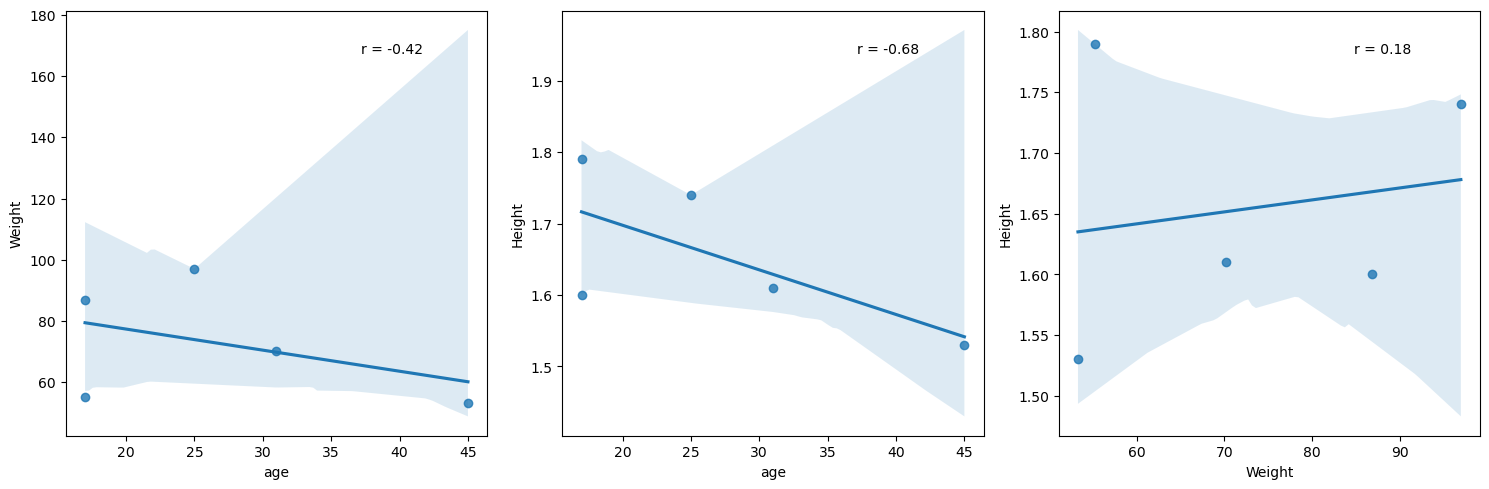

In [146]:
df_cleaned = df.dropna()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.regplot(x='age', y='Weight', data=df_cleaned)
r, _ = pearsonr(df_cleaned['age'], df_cleaned['Weight'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.subplot(1, 3, 2)
sns.regplot(x='age', y='Height', data=df_cleaned)
r, _ = pearsonr(df_cleaned['age'], df_cleaned['Height'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.subplot(1, 3, 3)
sns.regplot(x='Weight', y='Height', data=df_cleaned)
r, _ = pearsonr(df_cleaned['Weight'], df_cleaned['Height'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()

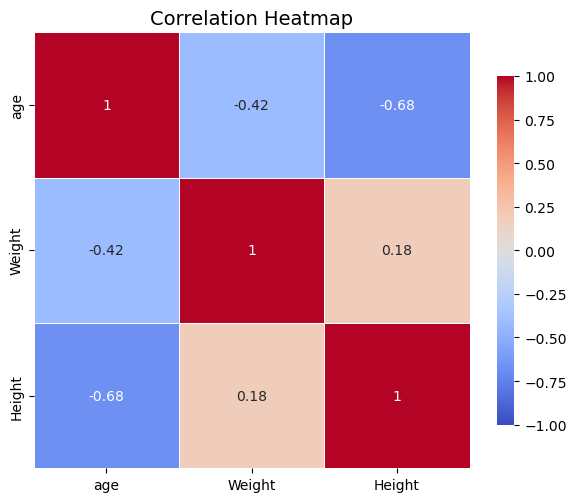

In [147]:
cor_mat = df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()


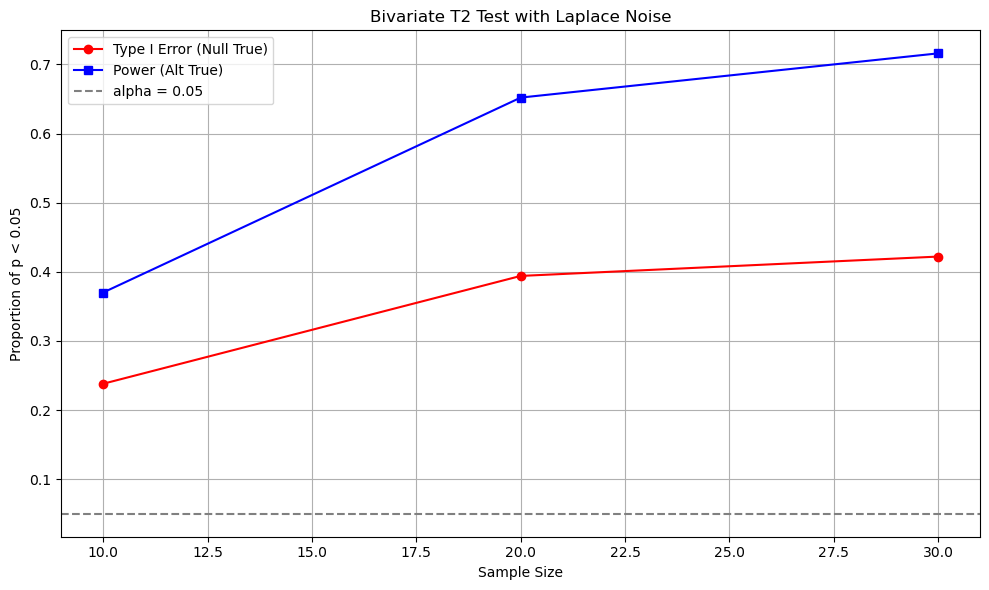

In [151]:
from scipy.stats import f, multivariate_normal

def noisy_t2_test(X, mu0, noise_scale=0.5, add_cov_noise=True):
    n, p = X.shape
    x_bar = np.mean(X, axis=0)
    S = np.cov(X, rowvar=False)

    noisy_mean = x_bar + np.random.laplace(0, noise_scale, size=p)

    if add_cov_noise:
        noise_matrix = np.random.laplace(0, noise_scale, size=(p, p))
        noise_matrix = (noise_matrix + noise_matrix.T) / 2  
        noisy_cov = S + noise_matrix
    else:
        noisy_cov = S

    diff = noisy_mean - mu0
    try:
        T2 = n * diff.T @ np.linalg.inv(noisy_cov) @ diff
    except np.linalg.LinAlgError:
        return np.nan, np.nan

    F_stat = (n - p) / (p * (n - 1)) * T2
    pval = 1 - f.cdf(F_stat, dfn=p, dfd=n - p)
    return T2, pval

n_replicates = 500
sample_sizes = [10, 20, 30]
mu0 = np.array([0, 0])
mu1 = np.array([0.5, 0.5])
cov = np.array([[1, 0.5], [0.5, 1]])
noise_scale = 0.3

type1_rates = []
power_rates = []

for n in sample_sizes:
    type1, power = [], []
    for _ in range(n_replicates):
        X_null = np.random.multivariate_normal(mu0, cov, size=n)
        X_alt = np.random.multivariate_normal(mu1, cov, size=n)

        _, pval_null = noisy_t2_test(X_null, mu0, noise_scale=noise_scale, add_cov_noise=True)
        _, pval_alt = noisy_t2_test(X_alt, mu0, noise_scale=noise_scale, add_cov_noise=True)

        if not np.isnan(pval_null):
            type1.append(pval_null < 0.05)
        if not np.isnan(pval_alt):
            power.append(pval_alt < 0.05)

    type1_rates.append(np.mean(type1))
    power_rates.append(np.mean(power))

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, type1_rates, marker='o', color='red', label='Type I Error (Null True)')
plt.plot(sample_sizes, power_rates, marker='s', color='blue', label='Power (Alt True)')
plt.axhline(0.05, linestyle='--', color='gray', label='alpha = 0.05')
plt.xlabel('Sample Size')
plt.ylabel('Proportion of p < 0.05')
plt.title("Bivariate T2 Test with Laplace Noise")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


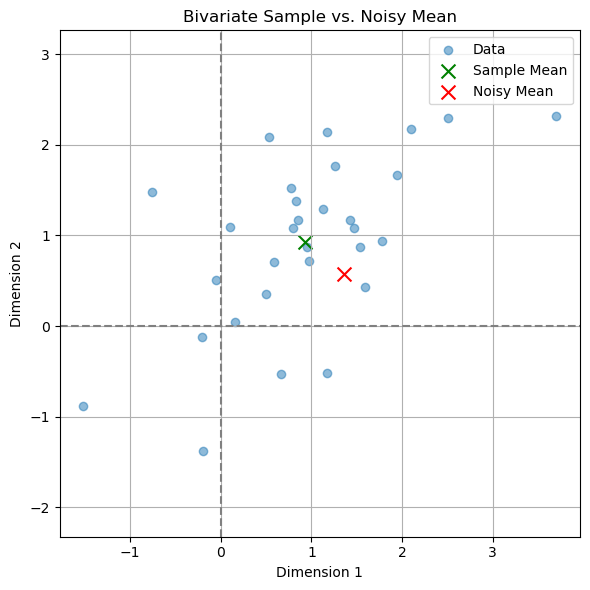

In [3]:
X = np.random.multivariate_normal(mu1, cov, size=30)
sample_mean = np.mean(X, axis=0)
noisy_mean = sample_mean + np.random.laplace(0, noise_scale, size=2)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Data')
plt.scatter(*sample_mean, color='green', label='Sample Mean', s=100, marker='x')
plt.scatter(*noisy_mean, color='red', label='Noisy Mean', s=100, marker='x')
plt.axhline(mu0[1], linestyle='--', color='gray')
plt.axvline(mu0[0], linestyle='--', color='gray')
plt.title('Bivariate Sample vs. Noisy Mean')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


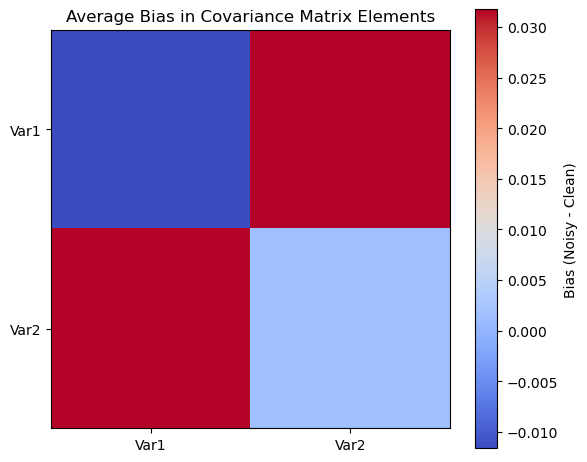

In [148]:
from numpy.linalg import eigh

n_samples = 50
n_replicates = 300
mu = np.array([0, 0])
cov_true = np.array([[1, 0.8], [0.8, 1]])
noise_scale = 0.3

clean_covs = []
noisy_covs = []
t2_clean = []
t2_noisy = []

for _ in range(n_replicates):
    X = np.random.multivariate_normal(mu, cov_true, size=n_samples)
    
    mean = np.mean(X, axis=0)
    S_clean = np.cov(X, rowvar=False)
    S_noisy = S_clean + np.random.laplace(0, noise_scale, size=(2, 2))
    S_noisy = (S_noisy + S_noisy.T) / 2  

    diff = mean - mu
    T2_clean = n_samples * diff.T @ np.linalg.inv(S_clean) @ diff
    T2_noisy = n_samples * diff.T @ np.linalg.inv(S_noisy) @ diff

    clean_covs.append(S_clean)
    noisy_covs.append(S_noisy)
    t2_clean.append(T2_clean)
    t2_noisy.append(T2_noisy)

clean_covs = np.array(clean_covs)
noisy_covs = np.array(noisy_covs)

bias_matrix = np.mean(noisy_covs - clean_covs, axis=0)

plt.figure(figsize=(6, 5))
plt.imshow(bias_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Bias (Noisy - Clean)')
plt.title('Average Bias in Covariance Matrix Elements')
plt.xticks([0,1], ['Var1', 'Var2'])
plt.yticks([0,1], ['Var1', 'Var2'])
plt.tight_layout()
plt.show()



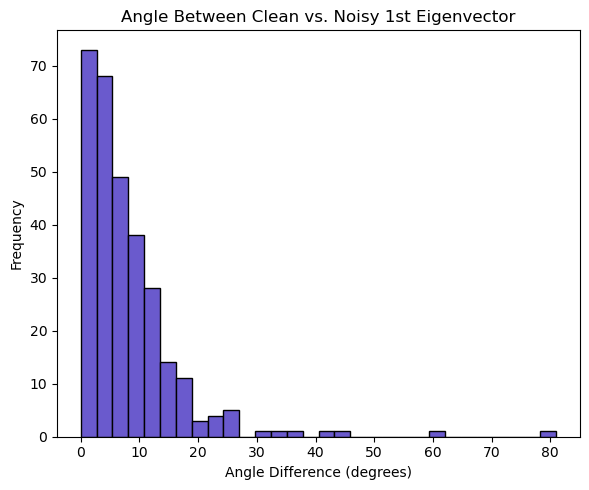

In [149]:

eig_diffs = []

for i in range(n_replicates):
    _, vecs_clean = eigh(clean_covs[i])
    _, vecs_noisy = eigh(noisy_covs[i])
    angle_diff = np.arccos(np.clip(np.abs(np.dot(vecs_clean[:, 1], vecs_noisy[:, 1])), -1, 1))
    eig_diffs.append(np.degrees(angle_diff))

plt.figure(figsize=(6, 5))
plt.hist(eig_diffs, bins=30, color='slateblue', edgecolor='black')
plt.title('Angle Between Clean vs. Noisy 1st Eigenvector')
plt.xlabel('Angle Difference (degrees)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


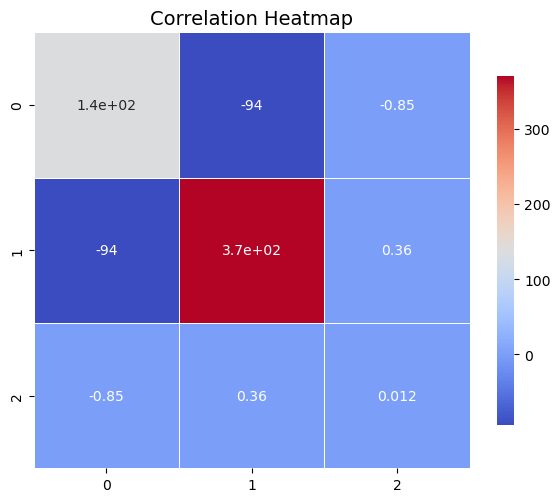

In [153]:
cor_mat = np.array(df.cov())

plt.figure(figsize=(6, 5))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm',
           square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

In [152]:
df.cov()

,age,Weight,Height
age,136.00,-93.70000,-0.85000
Weight,-93.70,370.20700,0.36465
Height,-0.85,0.36465,0.01153
